# Imports Libraries and Tools

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({
    'figure.dpi': 150,
    'savefig.dpi': 600,
    'savefig.format': 'pdf',
    'savefig.bbox': 'tight',
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'legend.frameon': True,
    'legend.framealpha': 1.0,
    'legend.edgecolor': '#000000',
    'legend.fancybox': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.linewidth': 1.5,
    'axes.grid': False,
    'lines.linewidth': 2.5,
    'lines.markersize': 8,
    'patch.linewidth': 1.5,
    'patch.edgecolor': '#000000',
    'text.color': '#000000',
    'axes.labelcolor': '#000000',
    'axes.edgecolor': '#000000',
    'xtick.color': '#000000',
    'ytick.color': '#000000',
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
})

In [2]:
import os
import random  
from PIL import Image, ImageEnhance  
from tensorflow.keras.preprocessing.image import load_img  
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.applications import VGG16  
from sklearn.utils import shuffle  

2025-10-06 16:30:28.701299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759768228.869541      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759768228.920147      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Brain Tumor & MRI Basics**

Brain tumor = abnormal growth of cells inside the brain. Can be benign (non-cancerous) or malignant (cancerous).

MRI (Magnetic Resonance Imaging) = most common scan used to detect brain tumors because it shows soft tissues of the brain in high detail.

**Labels/categories in a brain tumor MRI dataset**

Here’s what each means:

Pituitary → Tumor in the pituitary gland (a small gland at the base of the brain that controls hormones).

Meningioma → Tumor in the meninges (the protective layers covering the brain/spinal cord). Usually slow-growing and often benign.

Glioma → Tumor in the glial cells (support cells in the brain). Includes astrocytomas, oligodendrogliomas, and glioblastomas. Often malignant.

Notumor → Normal brain MRI with no tumor present.

# Load Datasets

In [3]:
# Directories for training and testing data
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

In [4]:
# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

In [5]:
# train_paths

In [6]:
# test_paths

In [7]:
print(f"Training samples: {len(train_paths)}, Test samples: {len(test_paths)}")

Training samples: 5712, Test samples: 1311


# Data Visualization

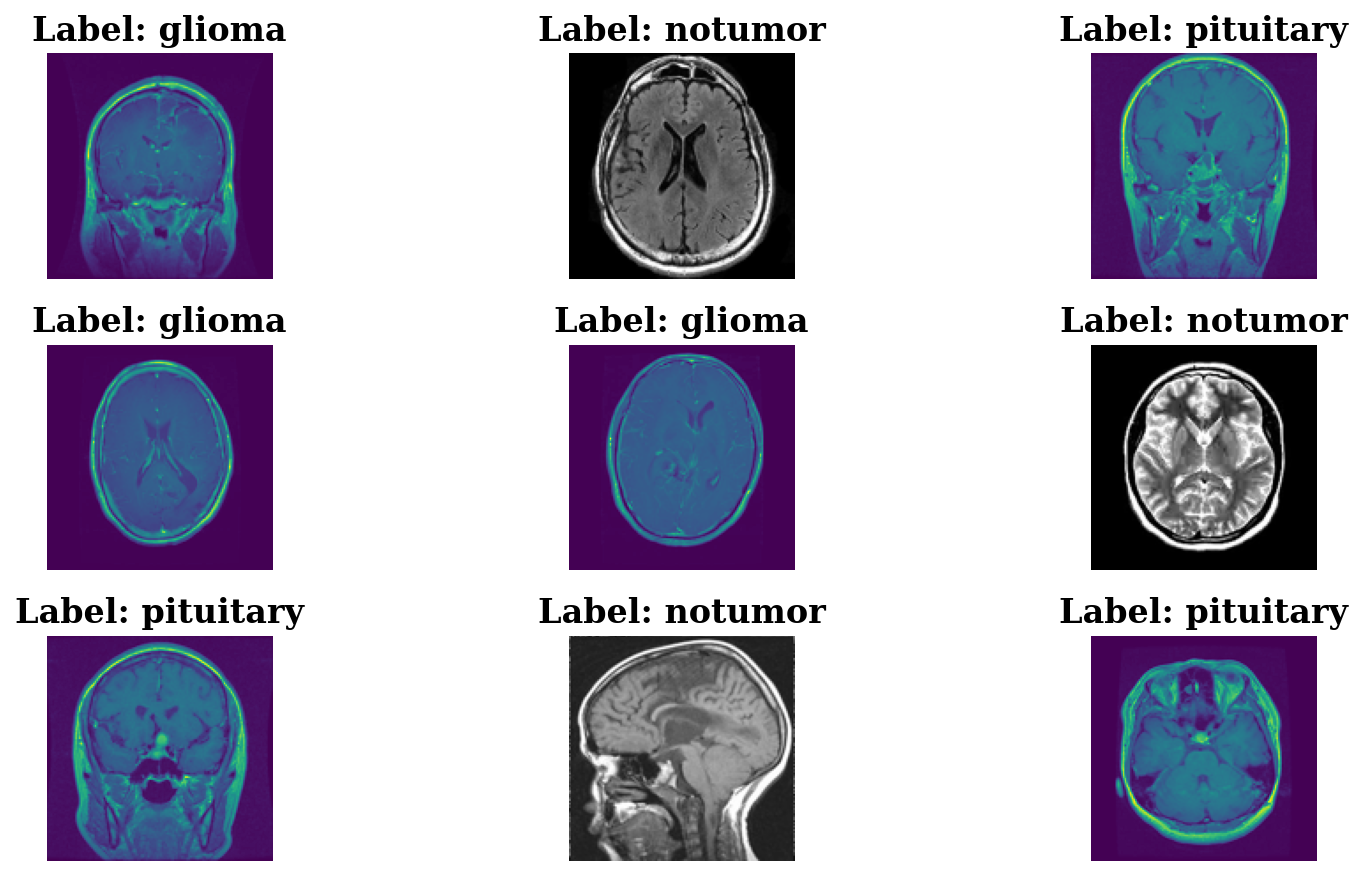

In [8]:
from PIL import Image

# Select random indices for 9 images
sample_indices = random.sample(range(len(train_paths)), 9)

plt.figure(figsize=(12, 6))

for i, sample_idx in enumerate(sample_indices):
    im = Image.open(train_paths[sample_idx]).resize((128, 128))
    
    plt.subplot(3, 3, i+1)   
    plt.imshow(im)  
    plt.axis("off")
    plt.title(f"Label: {train_labels[sample_idx]}")  

plt.tight_layout()
plt.show()


**Let's check class imbalance**

In [9]:
base_dir = "/kaggle/input/brain-tumor-mri-dataset"

def get_class_counts(split):
    split_dir = os.path.join(base_dir, split)
    class_counts = {}
    for cls in os.listdir(split_dir):
        cls_path = os.path.join(split_dir, cls)
        if os.path.isdir(cls_path):
            class_counts[cls] = len(os.listdir(cls_path))
    return class_counts

# Training counts
train_counts = get_class_counts("Training")

# Testing counts
test_counts = get_class_counts("Testing")

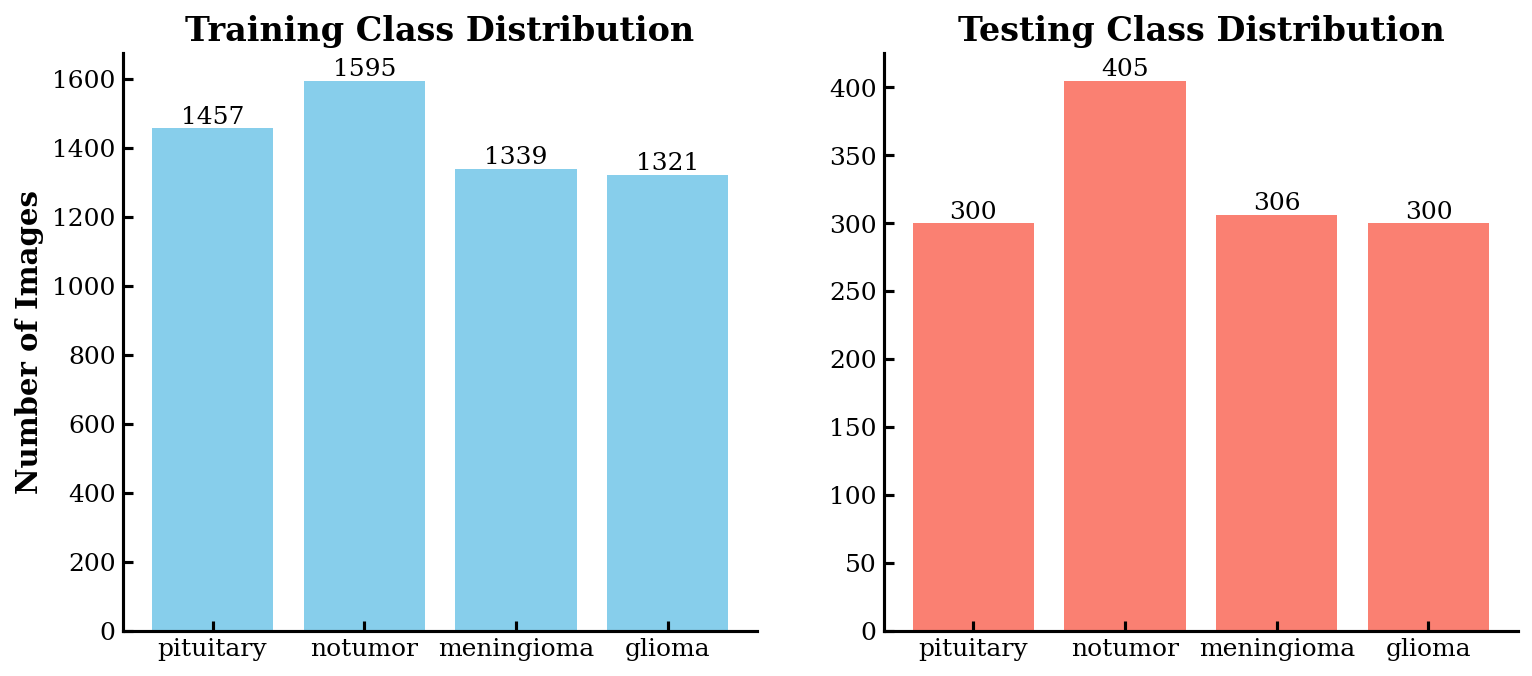

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training plot
bars1 = axes[0].bar(train_counts.keys(), train_counts.values(), color="skyblue")
axes[0].set_title("Training Class Distribution")
axes[0].set_ylabel("Number of Images")
axes[0].bar_label(bars1)   

# Testing plot
bars2 = axes[1].bar(test_counts.keys(), test_counts.values(), color="salmon")
axes[1].set_title("Testing Class Distribution")
axes[1].bar_label(bars2)   

plt.show()

The dataset is overall balanced.

# Image Preprocessing

In [11]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# MODEL: VGG16 FOR TRANSFER LEARNING

In [12]:
IMAGE_SIZE = 224 
base_model = VGG16(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), 
    include_top=False, 
    weights='imagenet')

base_model.trainable = True

for layer in base_model.layers[:-4]:
    layer.trainable = False

base_model.summary()

I0000 00:00:1759768241.996234      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759768241.996904      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [13]:
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

Layer 0: input_layer, Trainable: False
Layer 1: block1_conv1, Trainable: False
Layer 2: block1_conv2, Trainable: False
Layer 3: block1_pool, Trainable: False
Layer 4: block2_conv1, Trainable: False
Layer 5: block2_conv2, Trainable: False
Layer 6: block2_pool, Trainable: False
Layer 7: block3_conv1, Trainable: False
Layer 8: block3_conv2, Trainable: False
Layer 9: block3_conv3, Trainable: False
Layer 10: block3_pool, Trainable: False
Layer 11: block4_conv1, Trainable: False
Layer 12: block4_conv2, Trainable: False
Layer 13: block4_conv3, Trainable: False
Layer 14: block4_pool, Trainable: False
Layer 15: block5_conv1, Trainable: True
Layer 16: block5_conv2, Trainable: True
Layer 17: block5_conv3, Trainable: True
Layer 18: block5_pool, Trainable: True


In [14]:
# Build the transfer model
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(os.listdir(train_dir)), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,068 (56.64 MB)

 Trainable params: 7,212,292 (27.51 MB)

 Non-trainable params: 7,635,776 (29.13 MB)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

batch_size = 32
train_steps = len(train_paths) // batch_size
val_steps = len(test_paths) // batch_size
epochs = 25

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

history = model.fit(
    datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_data=datagen(test_paths, test_labels, batch_size=batch_size, epochs=epochs),
    validation_steps=val_steps,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/25


I0000 00:00:1759768248.242031      64 service.cc:148] XLA service 0x7b9de0002a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759768248.242913      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759768248.242932      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759768248.752924      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/178 ━━━━━━━━━━━━━━━━━━━━ 48:54 17s/step - accuracy: 0.3750 - loss: 1.6931

I0000 00:00:1759768261.153252      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


178/178 ━━━━━━━━━━━━━━━━━━━━ 89s 412ms/step - accuracy: 0.5582 - loss: 1.1579 - val_accuracy: 0.8289 - val_loss: 0.4743 - learning_rate: 1.0000e-04
Epoch 2/25
178/178 ━━━━━━━━━━━━━━━━━━━━ 52s 244ms/step - accuracy: 0.8633 - loss: 0.3765 - val_accuracy: 0.9008 - val_loss: 0.2631 - learning_rate: 1.0000e-04
Epoch 3/25
178/178 ━━━━━━━━━━━━━━━━━━━━ 46s 257ms/step - accuracy: 0.9123 - loss: 0.2554 - val_accuracy: 0.9250 - val_loss: 0.2028 - learning_rate: 1.0000e-04
Epoch 4/25
178/178 ━━━━━━━━━━━━━━━━━━━━ 56s 316ms/step - accuracy: 0.9436 - loss: 0.1637 - val_accuracy: 0.9554 - val_loss: 0.1251 - learning_rate: 1.0000e-04
Epoch 5/25
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 250ms/step - accuracy: 0.9564 - loss: 0.1212 - val_accuracy: 0.9633 - val_loss: 0.1142 - learning_rate: 1.0000e-04
Epoch 6/25
178/178 ━━━━━━━━━━━━━━━━━━━━ 45s 251ms/step - accuracy: 0.9739 - loss: 0.0699 - val_accuracy: 0.9640 - val_loss: 0.1036 - learning_rate: 1.0000e-04
Epoch 7/25
178/178 ━━━━━━━━━━━━━━━━━━━━ 45s 254ms/step - 

# Loss and Accuracy Plots

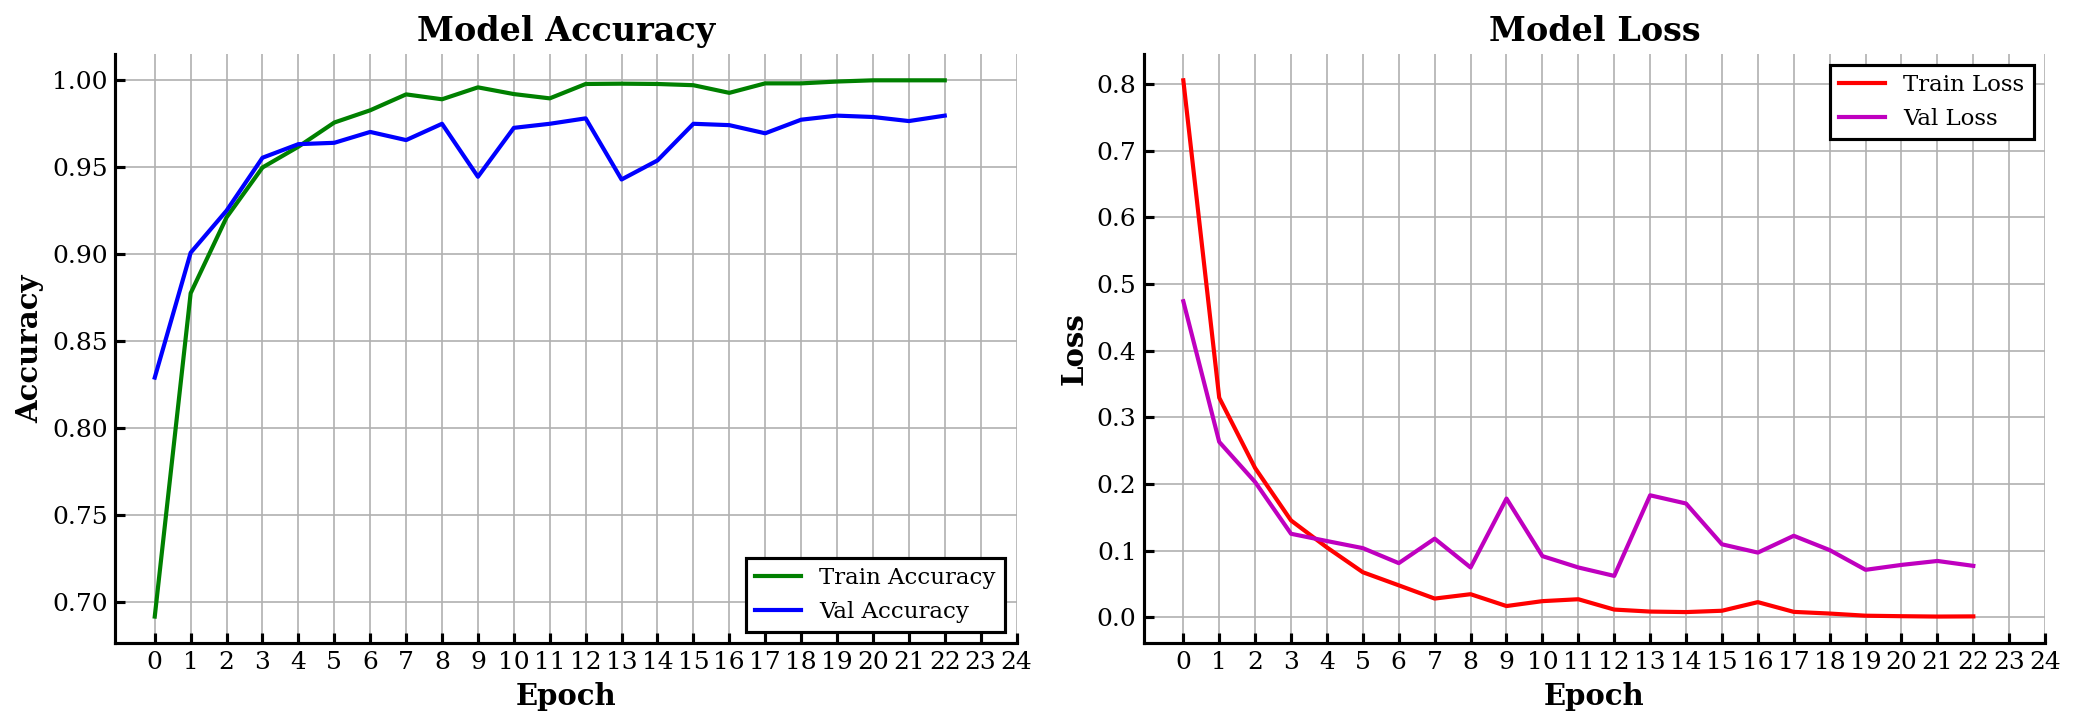

In [16]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'g-', linewidth=2, label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'b-', linewidth=2, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(epochs))
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'r-', linewidth=2, label='Train Loss')
plt.plot(history.history['val_loss'], 'm-', linewidth=2, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(epochs))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Model Classification Report

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       300
           1       1.00      1.00      1.00       405
           2       0.98      0.90      0.94       306
           3       0.93      0.99      0.96       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



# Model Confusion Plot

Confusion Matrix:
[[295   0   4   1]
 [  0 405   0   0]
 [  8   2 276  20]
 [  0   0   2 298]]


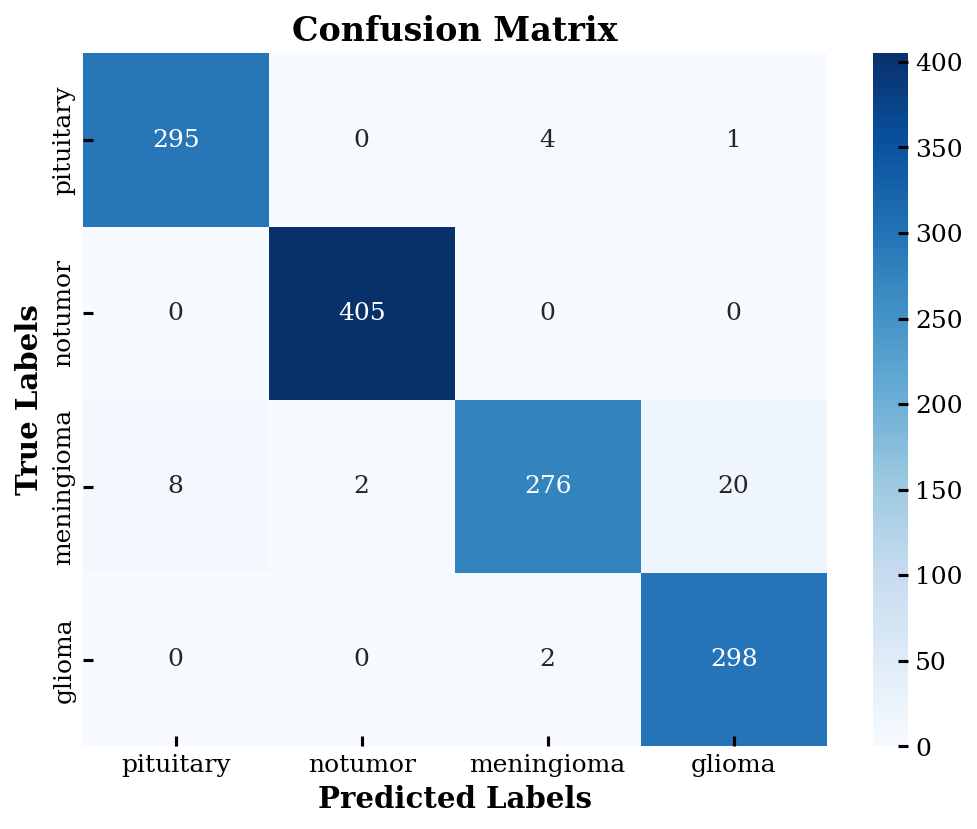

In [18]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Roc Curve Plot


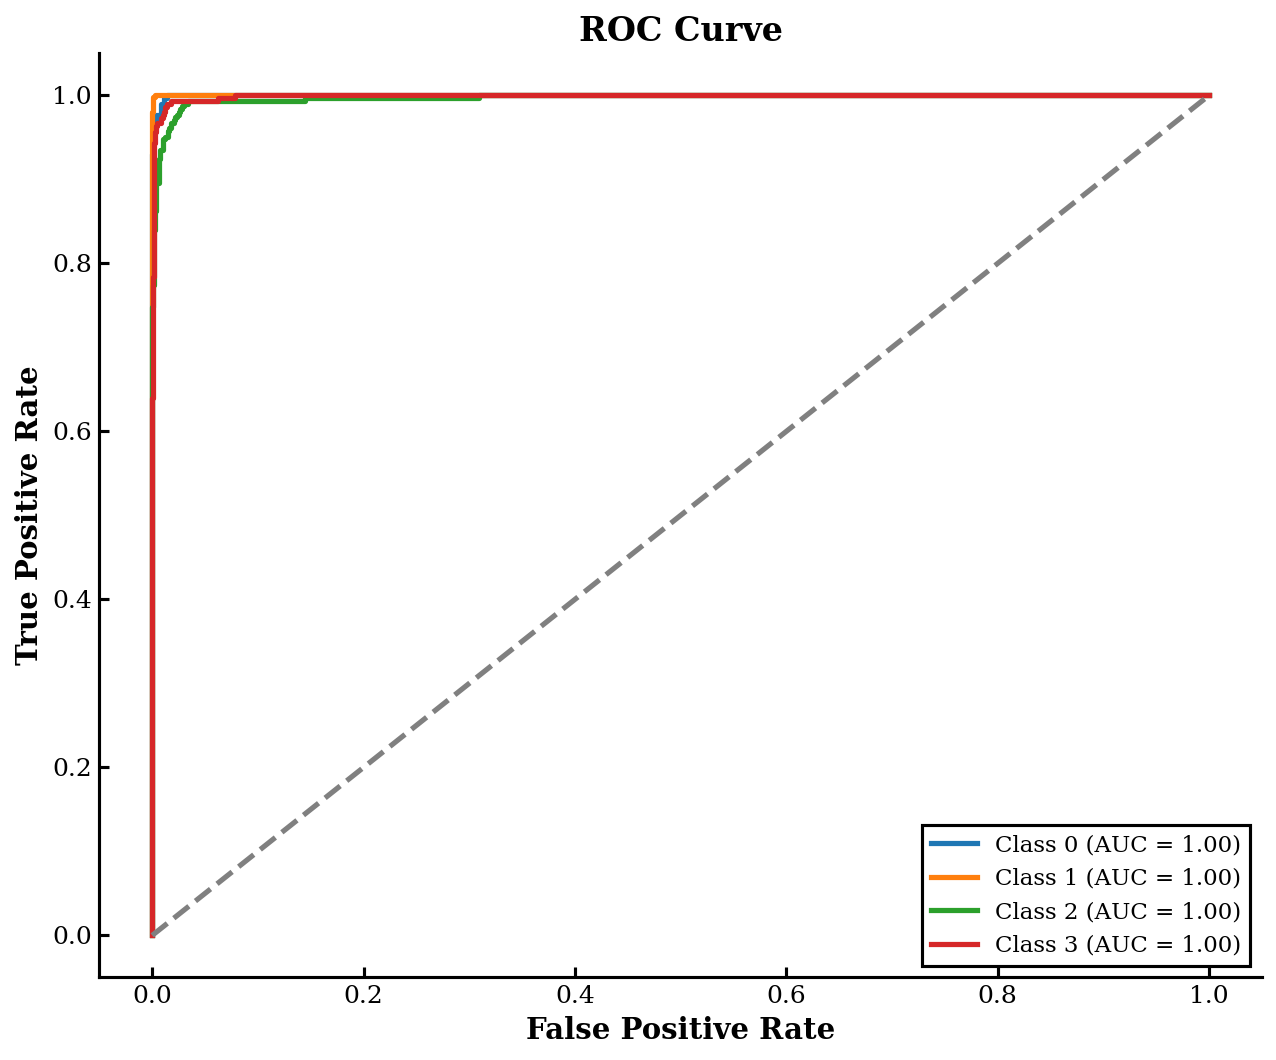

In [19]:
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model

# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Save & Load Model

In [20]:
# Save the entire model
# model.save('model.keras')

In [21]:
# from tensorflow.keras.models import load_model
# # Load the trained model
# model = load_model('model.keras')

# MRI Tumor Detection System

In [22]:
from keras.preprocessing.image import load_img, img_to_array

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=224):
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


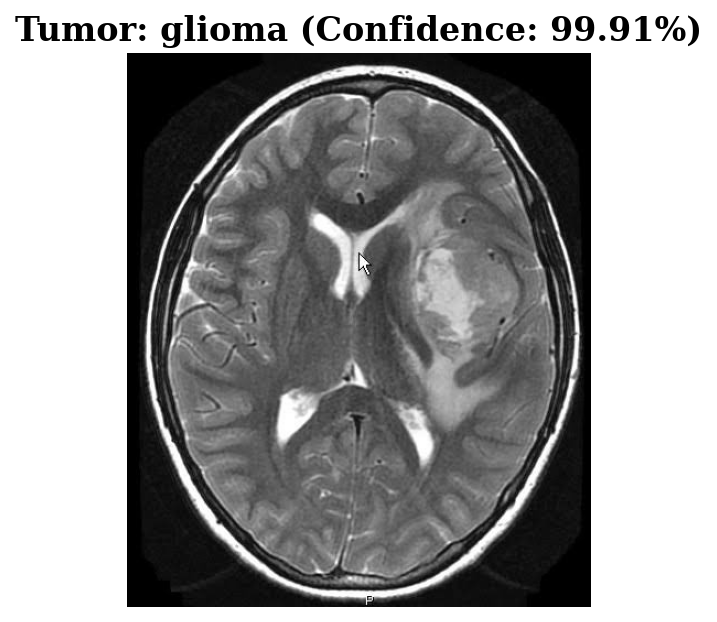

In [23]:
path = '/kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor/image(18).jpg'
detect_and_display(path, model)

In [24]:
# path = '/kaggle/input/brain-tumor-classification-mri/Testing/no_tumor/image(17).jpg'
# detect_and_display(path, model)